In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import fftlog
import twobessel

## Ingredients to boost computational speed
What we need to evaluate fast are Eqs.(55), numerator of (48) of https://arxiv.org/abs/1206.6890v1.

$$
\begin{align}
    J_{n}(r) = \frac{1}{r^n}\int_0^r\xi_{\rm gg}^{\rm lin}(y)y^{n-1}{\rm d}y
\end{align}
$$
and 
$$
\begin{align}
    n_{48} = \int_0^{r_{\rm max}} \xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_{\Pi}) {\rm d}r_{\Pi},
\end{align}
$$
where
$$
\begin{align}
    \xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_{\Pi}) = \sum_{l=0}^{2} \xi_{2l}(s) {\cal P}_{2l}(\mu)
\end{align}
$$
Here $s=\sqrt{r_{\rm p}^2+r_{\Pi}^2}$ and $\mu=r_\Pi/s$.

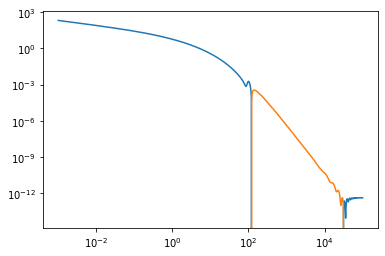

In [4]:
r, xi = np.loadtxt('xi.txt', unpack=True)
plt.figure()
plt.loglog(r, xi)
plt.loglog(r,-xi)
plt.show()

### $J_n$
Using FFTLog of $\xi_{\rm gg}^{\rm lin}(r)r^3$
$$
\begin{align}
    \xi_{\rm gg}^{\rm lin}(y)y^3 = \frac{1}{N}\sum_{m=-N/2}^{N/2} c_m y_0^\nu \left(\frac{y}{y_0}\right)^{\nu+i\eta_m},
\end{align}
$$
where $\eta_m=2\pi m/N\Delta y$, we can evaluate $J_n$ as 
$$
\begin{align}
    J_n(r) 
    &= \frac{1}{N}\sum_{m=-N/2}^{N/2} c_m y_0^{-i\eta_m} \frac{1}{r^n}\int_0^r{\rm d}y~y^{n-1-3+\nu+i\eta_m} \\
    &= \frac{1}{N}\sum_{m=-N/2}^{N/2} \frac{c_m}{n+\nu-3+i\eta_m} y_0^{-i\eta_m} r^{\nu-3+i\eta_m}
\end{align}
$$
Hence
$$
\begin{align}
    J_n(r_i) = 
    &= r_i^{\nu-3} {\rm iFFTLog}\left[\frac{c_m^*}{n+\nu-3-i\eta_m} (y_0r_0)^{i\eta_m} \right]
\end{align}
$$

In [10]:
def Jn_direct(n, r, xi):
    dlnr = np.log(r[1]/r[0])
    integr = xi*r**(n-1)
    ans = np.array([ np.sum( integr[r<_r])*dlnr for _r in r]) / r**n
    return ans

In [19]:
%time Jn_d = Jn_direct(3, r, xi)

CPU times: user 9.37 ms, sys: 111 µs, total: 9.48 ms
Wall time: 9.1 ms


In [58]:
n = 3
f = fftlog.fftlog(r, xi*r**3, nu=1.01)#, N_extrap_low=512, N_extrap_high=512, c_window_width=0.25)

r_fft = f.x
h_m = f.c_m / (n+f.nu-3+1j*f.eta_m) * (f.x[0]*r_fft[0])**(-1j*f.eta_m)
Jn = fftlog.irfft(np.conj(h_m)) * r_fft**(f.nu-3)
#h_m = f.c_m * (f.x[0]*r_fft[0])**(-1j*f.eta_m)
#Jn = fftlog.irfft(np.conj(h_m)) * r_fft**(f.nu-3)
#Jn = Jn[::-1

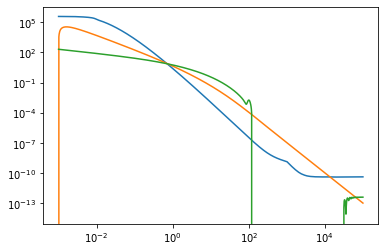

In [59]:
plt.figure()
plt.loglog(r_fft, Jn)
plt.loglog(r, Jn_d)
plt.loglog(r, xi)
plt.show()

### $n_{48}$
Using 2DFFTLog of $\xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_\Pi)$,
$$
\begin{align}
    \xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_\Pi) = \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} c_{mn} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} r_{\Pi0}^\nu\left(\frac{r_{\Pi}}{r_{\Pi0}}\right)^{\nu_2+i\eta_n} 
    \equiv r_{\rm p}^{\nu_1} r_\Pi^{\nu_2} {\rm 2DFFTLog}[c_{mn}r_{\rm p0}^{-i\eta_m}r_\Pi^{-i\eta_n}](r_{\rm p}, r_{\rm max})
\end{align}
$$
we can evaluate $n_{48}$ as 
$$
\begin{align}
    n_{48} 
    &= \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} c_{mn} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} 
    r_{\Pi0}^{-i\eta_n}
    \int_0^{r_{\rm max}} {\rm d}r_\Pi r_{\Pi}^{\nu_2+i\eta_n} \\
    &= \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} \frac{c_{mn}}{\nu_2+i\eta_n+1} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} 
    r_{\Pi0}^{-i\eta_n} r_{\rm max}^{\nu_2+1+i\eta_n} \\
    &= {\rm i2DFFTLog}\left[\frac{c_{mn}^*}{\nu_2+1-i\eta_n}\right](r_{\rm p}, r_{\rm max})
\end{align}
$$

### $n_{48}$
Using 2DFFTLog of $\xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_\Pi)$,
$$
\begin{align}
    \xi_{\rm gg}^{\rm lin}(r_{\rm p}, r_\Pi) = \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} c_{mn} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} r_{\Pi0}^\nu\left(\frac{r_{\Pi}}{r_{\Pi0}}\right)^{\nu_2+i\eta_n} 
    \equiv r_{\rm p}^{\nu_1} r_\Pi^{\nu_2} {\rm 2DFFTLog}[c_{mn}r_{\rm p0}^{-i\eta_m}r_\Pi^{-i\eta_n}](r_{\rm p}, r_{\rm max})
\end{align}
$$
we can evaluate $n_{48}$ as 
$$
\begin{align}
    n_{48} 
    &= \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} c_{mn} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} 
    r_{\Pi0}^{-i\eta_n}
    \int_0^{r_{\rm max}} {\rm d}r_\Pi r_{\Pi}^{\nu_2+i\eta_n} \\
    &= \frac{1}{N_1N_2}\sum_{m=-N_1/2}^{N_1/2} \sum_{n=-N_2/2}^{N_2/2} \frac{c_{mn}}{\nu_2+i\eta_n+1} r_{\rm p0}^\nu\left(\frac{r_{\rm p}}{r_{\rm p0}}\right)^{\nu_1+i\eta_m} 
    r_{\Pi0}^{-i\eta_n} r_{\rm max}^{\nu_2+1+i\eta_n} \\
    &= r_{\rm p}^{\nu_1} r_{\rm max}^{\nu_2+1} {\rm i2DFFTLog}\left[\frac{c_{mn}^*}{\nu_2+1-i\eta_n} r_{\rm p0}^{i\eta_m} r_{\Pi0}^{i\eta_n} \right](r_{\rm p}, r_{\rm max})
\end{align}
$$